In [ ]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R

def transform_to_camera_frame(point, transform_matrix):
    """将点从机械臂基座坐标系转换到相机坐标系"""
    point_homogeneous = np.append(point, 1)  # 转换为齐次坐标
    point_camera = np.dot(transform_matrix, point_homogeneous)
    return point_camera[:3]  # 返回非齐次坐标

def project_to_image(point, camera_matrix):
    """将相机坐标系中的 3D 点投影到图像平面"""
    point_homogeneous = np.append(point, 1)  # 转换为齐次坐标
    point_image = np.dot(camera_matrix, point_homogeneous[:3])
    point_image = point_image / point_image[2]  # 归一化
    return point_image[:2]  # 返回图像平面上的 2D 坐标


def calculate_gripper_keypoints(eef_pos, eef_quat, gripper_qpos):
    """
    根据 EEF 位姿和夹爪状态计算 PandaGripper 关键点的 3D 坐标。

    Args:
        eef_pos (np.array): 末端执行器（EEF）的位置 (x, y, z)。
        eef_quat (np.array): 末端执行器的姿态 (四元数)。
        gripper_qpos (float): 夹爪的关节状态（开合距离）。

    Returns:
        list: 夹爪关键点的 3D 坐标（例如两个指尖的位置）。
    """
    # PandaGripper 的几何参数
    fingertip_offset = 0.05  # 夹爪指尖到 EEF 中心的偏移量（单位：米）
    finger_length = 0.1  # 夹爪手指的长度（单位：米）

    # 计算夹爪的开口宽度
    gripper_width = gripper_qpos * fingertip_offset  # 根据关节状态计算开口宽度

    # 获取末端执行器的旋转矩阵
    rotation = R.from_quat(eef_quat).as_matrix()

    # 计算夹爪指尖的局部坐标
    left_fingertip_local = np.array([-gripper_width / 2, 0, -finger_length])
    right_fingertip_local = np.array([gripper_width / 2, 0, -finger_length])

    # 将局部坐标转换到世界坐标系
    left_fingertip_world = eef_pos + np.dot(rotation, left_fingertip_local)
    right_fingertip_world = eef_pos + np.dot(rotation, right_fingertip_local)

    # 返回关键点的 3D 坐标
    keypoints = [left_fingertip_world, right_fingertip_world]
    return keypoints

def draw_keypoints(image, keypoints):
    """在图像上绘制关键点"""
    for point in keypoints:
        x, y = int(point[0]), int(point[1])
        print(x, y)
        cv2.circle(image, (x, y), 5, (255, 0, 0), -1)  # 绘制红色圆点

# 示例数据
import numpy as np
eef_pos = np.array([-0.20763411, -0.01452589,  1.17790649])  # EEF 位置（机械臂基座坐标系）
eef_quat = np.array([ 9.99571518e-01, -9.23849986e-04, -2.92559594e-02,  1.27680686e-04])  # EEF 姿态（四元数，单位四元数表示无旋转）
gripper_qpos = -0.9933217915098023  # 夹爪关节状态（假设为开合距离）
# 计算夹爪关键点的 3D 坐标
gripper_keypoints_3d = calculate_gripper_keypoints(eef_pos, eef_quat, gripper_qpos)
print(gripper_keypoints_3d)

In [ ]:
# 相机参数
rotation_matrix_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/rotation_matrix.npy"
rotation_matrix = np.load(rotation_matrix_path)
translation_vector_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/translation_vector.npy"
translation_vector = np.load(translation_vector_path)

camera_matrix_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/intrinsic_matrix_agentview.npy"
camera_matrix = np.load(camera_matrix_path) # 相机内参
camera_name = "agentview" # 在examples/libero/.venv/lib/python3.8/site-packages/robosuite/robots/single_arm.py 中controller打断点，然后通过camera = self.sim.model.camera("robot0_eye_in_hand") 得到camera各种参数
transform_matrix_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/extrinsic_matrix_agentview.npy"
transform_matrix = np.load(transform_matrix_path)  # 相机外参
print(transform_matrix)

In [ ]:
# 将关键点转换到相机坐标系并投影到图像平面
keypoints_image = []
for point in gripper_keypoints_3d:
    point_camera = transform_to_camera_frame(point, transform_matrix)
    point_image = project_to_image(point_camera, camera_matrix)
    keypoints_image.append(point_image)

# 加载图像
image = cv2.imread("/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/base_image.png")

# 在图像上绘制关键点
draw_keypoints(image, keypoints_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 假设 image 是 OpenCV 格式的图像（BGR 格式）
# 将 BGR 图像转换为 RGB 格式
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 使用 matplotlib 显示图像
plt.figure(figsize=(10, 10))  # 设置图像显示大小
plt.imshow(image_rgb)
plt.title("Gripper Keypoints")  # 设置图像标题
plt.axis('off')  # 不显示坐标轴
plt.show()

# 2. how to get rotation_matrix & translation_vector 

In [ ]:
from robosuite.utils.camera_utils import get_camera_intrinsic_matrix, get_camera_extrinsic_matrix 
intrinsic_matrix = get_camera_intrinsic_matrix(self.sim, "frontview", 256, 256)
extrinsic_matrix = get_camera_extrinsic_matrix(self.sim, "frontview")


In [ ]:
output_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/extrinsic_matrix.npy"
np.save(extrinsic_matrix, output_path)

In [ ]:
import numpy as np
# eef_pos = np.array([-0.20763411, -0.01452589,  1.17790649, 1])  # EEF 位置（机械臂基座坐标系）
eef_pos = np.array([-0.20791166, -0.01446029,  1.17826226, 1])
camera_matrix_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/intrinsic_matrix_agentview.npy"
intrinsic_matrix = np.load(camera_matrix_path) # 相机内参
camera_name = "agentview" # 在examples/libero/.venv/lib/python3.8/site-packages/robosuite/robots/single_arm.py 中controller打断点，然后通过camera = self.sim.model.camera("robot0_eye_in_hand") 得到camera各种参数
transform_matrix_path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera/extrinsic_matrix_agentview.npy"
extrinsic_matrix = np.load(transform_matrix_path)  # 相机外参
print(intrinsic_matrix )

In [ ]:
intrinsic_matrix = np.array([[309.01933598,   0.        , 128.        ],
       [  0.        , 309.01933598, 128.        ],
       [  0.        ,   0.        ,   1.        ]])
extrinsic_matrix = np.array([[-5.55111512e-17, -2.58174524e-01,  9.66098295e-01,
         1.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  9.66098295e-01,  2.58174524e-01,
         1.48000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
eef_pos = np.array([-0.20763411, -0.01452589,  1.17790649, 1])

In [ ]:
eef_pos_camera = np.dot(extrinsic_matrix, eef_pos)
eef_pos_camera

In [ ]:
eef_pos_2d = np.dot(intrinsic_matrix, eef_pos_camera[:3])
eef_pos_2d = eef_pos_2d / eef_pos_2d[2]  # 归一化
eef_pos_2d

In [ ]:
from robosuite.utils.camera_utils import get_camera_transform_matrix, project_points_from_world_to_camera

point = obs['robot0_eef_pos']
img = wrist_img
path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/wrist_image_new2.png"
np.save(path, img)
transform_matrix = get_camera_transform_matrix(env.sim, "robot0_eye_in_hand", 256, 256)
tmp = project_points_from_world_to_camera(point, transform_matrix, 256, 256)

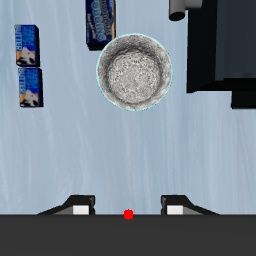

In [123]:
import cv2
from IPython.display import display, Image

# 假设 image 是你获取的图像
image = cv2.imread("/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/wrist_image_new2.png")

# 获取2D坐标
# x, y = int(eef_pos_2d[0]), int(eef_pos_2d[1])
x, y = int(109), int(120)
x, y = int(112), int(54)
x, y = int(135), int(191)
y, x = int(214), int(128)
# 在图像上绘制红色圆点
cv2.circle(image, (x, y), 5, (0, 0, 255), -1)  # 红色圆点，半径为5

# 将图像编码为 JPEG 格式
_, encoded_image = cv2.imencode('.jpg', image)

# 使用 IPython.display 显示图像
display(Image(data=encoded_image.tobytes()))

In [ ]:
from robosuite.utils.camera_utils import get_camera_transform_matrix, project_points_from_world_to_camera
import cv2 

point = obs['robot0_eef_pos']
path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/image_new2.png"
tmp_img = np.ascontiguousarray(obs["agentview_image"][::-1, ::-1])
cv2.imwrite(path, img)
transform_matrix = get_camera_transform_matrix(env.sim, "agentview", 256, 256)
tmp = project_points_from_world_to_camera(point, transform_matrix, 256, 256)

In [145]:
import cv2
from IPython.display import display, Image

# 假设 image 是你获取的图像
image = cv2.imread("/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera_img/image_new_11.png")

# 获取2D坐标
# x, y = int(eef_pos_2d[0]), int(eef_pos_2d[1])
x, y = int(109), int(120)
x, y = int(112), int(54)
x, y = int(135), int(191)
y, x = int(60), int(123)
# 在图像上绘制红色圆点
cv2.circle(image, (x, y), 5, (0, 0, 255), -1)  # 红色圆点，半径为5

# 将图像编码为 JPEG 格式
_, encoded_image = cv2.imencode('.jpg', image)

# 使用 IPython.display 显示图像
display(Image(data=encoded_image.tobytes()))

[ WARN:0@42200.722] global loadsave.cpp:241 findDecoder imread_('/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/camera_img/image_new_11.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:1134: error: (-215:Assertion failed) !image.empty() in function 'imencode'


In [134]:
path = "/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/test.png"
cv2.imwrite(path, image)

True

# 3. try remoteDetc

In [ ]:
import cv2 
kernel3 = np.ones((5, 5), np.float32) / 25
frame = cv2.imread("/storage/qiguojunLab/caojinjin/codes/openpi/dataloader/data/base_image.png")
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.filter2D(gray, -1, kernel3)


_, encoded_frame = cv2.imencode('.jpg', gray)

# 使用 IPython.display 显示图像
display(Image(data=encoded_frame.tobytes()))